<a href="https://colab.research.google.com/github/Siyan410/demo/blob/main/notebooks/book1/15/bert_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/15/bert_torch.ipynb

<a href="https://colab.research.google.com/github/codeboy5/probml-notebooks/blob/add-bert-jax/notebooks-d2l/bert_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT

We show how to implement BERT from scratch.
Based on sec 14.8 of http://d2l.ai/chapter_natural-language-processing-pretraining/bert.html




In [111]:
import jax
import jax.numpy as jnp  # JAX NumPy

try:
    from flax import linen as nn  # The Linen API
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax.core.frozen_dict import FrozenDict
from flax.core import freeze, unfreeze

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch.utils import data  # For data

import numpy as np  # Ordinary NumPy

try:
    import optax  # Optimizers
except ModuleNotFoundError:
    %pip install -qq optax
    import optax  # Optimizers

import collections
import re
import random
import os
import requests
import zipfile
import tarfile
import hashlib
import time
import json
import multiprocessing
from typing import Any, Callable, Sequence, Tuple
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython import display

rng = jax.random.PRNGKey(0)
!mkdir figures # for saving plots
ModuleDef = Any

mkdir: cannot create directory ‘figures’: File exists


# Data

We pretrain on wikitext 2.
This is  smaller than other corpora, so it trains in reasonable time. It retains the original punctuation, making it suitable for next sentence prediction.

Based on sec 14.9 of
http://d2l.ai/chapter_natural-language-processing-pretraining/bert-dataset.html


In [134]:
DATA_HUB = dict()
DATA_HUB["wikitext-2"] = (
    "https://s3.amazonaws.com/research.metamind.io/wikitext/" "wikitext-2-v1.zip",
    "3c914d17d80b1459be871a5039ac23e752a53cbe",
)


def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, "wiki.train.tokens")
    with open(file_name, "r") as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(" . ") for line in lines if len(line.split(" . ")) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

## Next sentence prediciton

In [135]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [136]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    tokens = ["<cls>"] + tokens_a + ["<sep>"]
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ["<sep>"]
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments


def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

## Masked language model

In [137]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    # Make a new copy of tokens for the input of a masked language model,
    # where the input may contain replaced '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = "<mask>"
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.randint(0, len(vocab) - 1)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [138]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ["<cls>", "<sep>"]:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab
    )
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

## Padding

In [139]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens, = (
        [],
        [],
        [],
    )
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab["<pad>"]] * (max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(
            torch.tensor(pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)), dtype=torch.long)
        )
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor(
                [1.0] * len(mlm_pred_label_ids) + [0.0] * (max_num_mlm_preds - len(pred_positions)), dtype=torch.float32
            )
        )
        all_mlm_labels.append(
            torch.tensor(mlm_pred_label_ids + [0] * (max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long)
        )
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)

## Putting it altogether

In [140]:
def tokenize(lines, token="word"):
    """Split text lines into word or character tokens."""
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("ERROR: unknown token type: " + token)


class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [141]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [tokenize(paragraph, token="word") for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = Vocab(sentences, min_freq=5, reserved_tokens=["<pad>", "<mask>", "<cls>", "<sep>"])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [
            (_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next))
            for tokens, segments, is_next in examples
        ]
        # Pad inputs
        (
            self.all_token_ids,
            self.all_segments,
            self.valid_lens,
            self.all_pred_positions,
            self.all_mlm_weights,
            self.all_mlm_labels,
            self.nsp_labels,
        ) = _pad_bert_inputs(examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (
            self.all_token_ids[idx],
            self.all_segments[idx],
            self.valid_lens[idx],
            self.all_pred_positions[idx],
            self.all_mlm_weights[idx],
            self.all_mlm_labels[idx],
            self.nsp_labels[idx],
        )

    def __len__(self):
        return len(self.all_token_ids)

In [145]:
# Required functions for downloading data


# def download(name, cache_dir=os.path.join("..", "data")):
#     """Download a file inserted into DATA_HUB, return the local filename."""
#     assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
#     url, sha1_hash = DATA_HUB[name]
#     os.makedirs(cache_dir, exist_ok=True)
#     fname = os.path.join(cache_dir, url.split("/")[-1])
#     if os.path.exists(fname):
#         sha1 = hashlib.sha1()
#         with open(fname, "rb") as f:
#             while True:
#                 data = f.read(1048576)
#                 if not data:
#                     break
#                 sha1.update(data)
#         if sha1.hexdigest() == sha1_hash:
#             return fname  # Hit cache
#     print(f"Downloading {fname} from {url}...")
#     r = requests.get(url, stream=True, verify=True)
#     with open(fname, "wb") as f:
#         f.write(r.content)
#     return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = "./wikitext-2-v1.zip"
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [146]:
def load_data_wiki(batch_size, max_len):
    num_workers = 4
    data_dir = download_extract("wikitext-2", "wikitext-2")
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [147]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
    print(
        tokens_X.shape,
        segments_X.shape,
        valid_lens_x.shape,
        pred_positions_X.shape,
        mlm_weights_X.shape,
        mlm_Y.shape,
        nsp_y.shape,
    )
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


# Model

## Encoder

In [158]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    tokens = ["<cls>"] + tokens_a + ["<sep>"]
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ["<sep>"]
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [159]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""

    dropout_rate: float

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    @nn.compact
    def __call__(self, queries, keys, values, train, valid_lens=None):
        d = queries.shape[-1]
        scores = queries @ (keys.swapaxes(1, 2)) / math.sqrt(d)
        attention_weights = masked_softmax(scores, valid_lens)
        dropout_layer = nn.Dropout(self.dropout_rate, deterministic=not train)
        return dropout_layer(attention_weights) @ values


class MultiHeadAttention(nn.Module):
    num_hiddens: int
    num_heads: int
    dropout: float
    bias: bool = False

    @nn.compact
    def __call__(self, queries, keys, values, valid_lens, train):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(nn.Dense(self.num_hiddens, use_bias=self.bias, name="W_q")(queries), self.num_heads)
        keys = transpose_qkv(nn.Dense(self.num_hiddens, use_bias=self.bias, name="W_k")(keys), self.num_heads)
        values = transpose_qkv(nn.Dense(self.num_hiddens, use_bias=self.bias, name="W_v")(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = jnp.repeat(valid_lens, self.num_heads, axis=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = DotProductAttention(self.dropout)(queries, keys, values, train, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return nn.Dense(self.num_hiddens, use_bias=self.bias, name="W_o")(output_concat)


class PositionWiseFFN(nn.Module):
    ffn_num_input: int
    ffn_num_hiddens: int
    ffn_num_outputs: int

    def setup(self):
        self.dense1 = nn.Dense(self.ffn_num_hiddens)
        self.relu = nn.relu
        self.dense2 = nn.Dense(self.ffn_num_outputs)

    def __call__(self, inputs):
        return self.dense2(self.relu(self.dense1(inputs)))


class AddNorm(nn.Module):
    dropout_rate: int

    def setup(self):
        self.dropout = nn.Dropout(self.dropout_rate)
        self.ln = nn.LayerNorm()

    def __call__(self, X, Y, train):
        return self.ln(self.dropout(Y, deterministic=not train) + X)


class EncoderBlock(nn.Module):
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    dropout_rate: float
    use_bias: bool = False

    def setup(self):
        self.attention = MultiHeadAttention(self.num_hiddens, self.num_heads, self.dropout_rate, self.use_bias)
        self.addnorm1 = AddNorm(self.dropout_rate)
        self.ffn = PositionWiseFFN(self.ffn_num_input, self.ffn_num_hiddens, self.num_hiddens)
        self.addnorm2 = AddNorm(self.dropout_rate)

    def __call__(self, X, valid_lens, train):
        output = self.attention(X, X, X, valid_lens, train)
        Y = self.addnorm1(X, output, train)
        return self.addnorm2(Y, self.ffn(Y), train)

In [160]:
class BERTEncoder(nn.Module):
    vocab_size: int
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    num_layers: int
    dropout: float
    max_len: int = 1000

    def setup(self):
        self.token_embedding = nn.Embed(self.vocab_size, self.num_hiddens, name="token_embedding")
        self.segment_embedding = nn.Embed(2, self.num_hiddens, name="segment_embedding")
        self.blks = [
            EncoderBlock(self.num_hiddens, self.ffn_num_input, self.ffn_num_hiddens, self.num_heads, self.dropout, True)
            for _ in range(self.num_layers)
        ]
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        pos_embed_shape = (1, self.max_len, self.num_hiddens)
        self.pos_embedding = self.param("embedding", nn.initializers.normal(), pos_embed_shape)

    def __call__(self, tokens, segments, valid_lens, train=True):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, : X.shape[1], :]
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens, train)
        return X

In [161]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = jnp.repeat(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.softmax(X.reshape(shape), axis=-1)


def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = jnp.arange((maxlen), dtype=jnp.float32)[None, :] < valid_len[:, None]
    X = jnp.where(~mask, value, X)
    return X


def transpose_qkv(X, num_heads):
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape((X.shape[0], X.shape[1], num_heads, -1))

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = jnp.transpose(X, (0, 2, 1, 3))

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape((-1, X.shape[2], X.shape[3]))


def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`"""
    X = X.reshape((-1, num_heads, X.shape[1], X.shape[2]))
    X = jnp.transpose(X, (0, 2, 1, 3))
    return X.reshape((X.shape[0], X.shape[1], -1))

In [162]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2

encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)

rng, i_rng = jax.random.split(rng)
tokens = jax.random.randint(i_rng, (2, 8), 0, vocab_size)
segments = jnp.array([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])

rng, i_rng = jax.random.split(rng)
params = encoder.init(i_rng, tokens, segments, None, False)
encoded_X = encoder.apply(params, tokens, segments, None, False)
encoded_X.shape

(2, 8, 768)

## Loss

In [163]:
class MaskLM(nn.Module):
    vocab_size: int
    num_hiddens: int

    @nn.compact
    def __call__(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = jnp.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = jnp.repeat(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        # MLP Layer
        mlm_Y_hat_ = nn.Dense(self.num_hiddens)(masked_X)
        mlm_Y_hat_ = nn.relu(mlm_Y_hat_)
        mlm_Y_hat_ = nn.LayerNorm(1e-5)(mlm_Y_hat_)
        mlm_Y_hat = nn.Dense(self.vocab_size)(mlm_Y_hat_)
        return mlm_Y_hat

In [164]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = jnp.array([[1, 5, 2], [6, 1, 5]])
rng, i_rng = jax.random.split(rng)
params = mlm.init(i_rng, encoded_X, mlm_positions)
mlm_Y_hat = mlm.apply(params, encoded_X, mlm_positions)
mlm_Y_hat.shape

(2, 3, 10000)

In [165]:
class NextSentencePred(nn.Module):
    @nn.compact
    def __call__(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        Y = nn.Dense(2)(X)
        return Y

In [166]:
encoded_X = jnp.reshape(encoded_X, (encoded_X.shape[0], -1))
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
rng, i_rng = jax.random.split(rng)
params = nsp.init(i_rng, encoded_X)
nsp_Y_hat = nsp.apply(params, encoded_X)
nsp_Y_hat.shape

(2, 2)

## Putting it altogether

In [167]:
class BERTModel(nn.Module):
    vocab_size: int
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    num_layers: int
    dropout: float
    maxlen: int = 1000

    def setup(self):
        self.encoder = BERTEncoder(
            self.vocab_size,
            self.num_hiddens,
            self.ffn_num_input,
            self.ffn_num_hiddens,
            self.num_heads,
            self.num_layers,
            self.dropout,
            self.maxlen,
        )
        self.mlm = MaskLM(self.vocab_size, self.num_hiddens)
        self.nsp = NextSentencePred()

    @nn.compact
    def __call__(self, tokens, segments, valid_lens=None, pred_positions=None, train=True):
        encoded_X = self.encoder(tokens, segments, valid_lens, train)
        # mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat_ = nn.Dense(self.num_hiddens, name="hidden")(encoded_X[:, 0, :])
        nsp_Y_hat_ = nn.tanh(nsp_Y_hat_)
        nsp_Y_hat = self.nsp(nsp_Y_hat_)
        return encoded_X, mlm_Y_hat, nsp_Y_hat

# Pre-training

In [168]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [169]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [170]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

Transformer = partial(
    BERTModel,
    vocab_size=len(vocab),
    num_hiddens=128,
    ffn_num_input=128,
    ffn_num_hiddens=256,
    num_heads=2,
    num_layers=2,
    dropout=0.2,
)

In [171]:
def cross_entropy_loss(logits, labels) -> float:
    one_hot = jax.nn.one_hot(labels, num_classes=logits.shape[1])
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot)
    return loss


def compute_metrics(logits, labels):
    """Computes metrics and returns them."""
    loss = cross_entropy_loss(logits, labels)
    metrics = {"loss": loss}
    return metrics

In [172]:
def get_initial_params(model, rng):
    """Returns the initial parameters of a bert model."""
    rng, i_rng = jax.random.split(rng)
    #! tokens, segments
    tokens = jnp.ones((512, 64), dtype=jnp.int32)
    segments = jnp.ones((512, 64), dtype=jnp.int32)
    positions = jnp.ones((512, 10), dtype=jnp.int32)
    rng, init_rng = jax.random.split(rng)
    variables = model.init(init_rng, tokens, segments, None, positions, False)
    return variables["params"]


def get_train_state(Model, rng, lr) -> train_state.TrainState:
    """Returns a train state."""
    model = Model()
    params = get_initial_params(model, rng)
    tx = optax.adam(lr)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [173]:
def train_step(
    state: train_state.TrainState,
    vocab_size,
    tokens_X,
    segments_X,
    valid_lens_x,
    pred_positions_X,
    mlm_weights_X,
    mlm_Y,
    nsp_y,
    dropout_rng,
):

    """Trains one step."""

    def loss_fn(params):
        # Forward pass
        _, mlm_Y_hat, nsp_Y_hat = state.apply_fn(
            {"params": params},
            tokens_X,
            segments_X,
            valid_lens_x.reshape(-1),
            pred_positions_X,
            True,
            rngs={"dropout": dropout_rng},
        )
        # Compute masked language model loss
        mlm_l = cross_entropy_loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1))
        mlm_weights_X.reshape((-1, 1))
        mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
        # Compute next sentence prediction loss
        nsp_l = cross_entropy_loss(nsp_Y_hat, nsp_y).mean()
        l = mlm_l + nsp_l
        return l, (mlm_l, nsp_l)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (l, (mlm_l, nsp_l)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    return mlm_l, nsp_l, l, state

In [174]:
def train_bert(Model, train_iter, lr, num_steps, vocab_size):

    key = jax.random.PRNGKey(314)
    state = get_train_state(Model, key, lr)

    step, timer = 0, Timer()
    animator = Animator(xlabel="step", ylabel="loss", xlim=[1, num_steps], legend=["mlm", "nsp"])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            key, dropout_rng = jax.random.split(key)
            tokens_X = jnp.array(tokens_X)
            segments_X = jnp.array(segments_X)
            valid_lens_x = jnp.array(valid_lens_x)
            pred_positions_X = jnp.array(pred_positions_X)
            mlm_weights_X = jnp.array(mlm_weights_X)
            mlm_Y = jnp.array(mlm_Y)
            nsp_y = jnp.array(nsp_y)
            timer.start()
            mlm_l, nsp_l, l, state = train_step(
                state,
                vocab_size,
                tokens_X,
                segments_X,
                valid_lens_x,
                pred_positions_X,
                mlm_weights_X,
                mlm_Y,
                nsp_y,
                dropout_rng,
            )
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
    device = jax.default_backend()
    print(f"MLM loss {metric[0] / metric[3]:.3f}, " f"NSP loss {metric[1] / metric[3]:.3f}")
    print(f"{metric[2] / timer.sum():.1f} sentence pairs/sec on " f"{str(device)}")

    return state

MLM loss 7.839, NSP loss 0.754
475.2 sentence pairs/sec on gpu


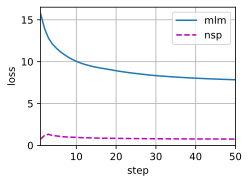

In [175]:
nsteps, lr = 50, 5e-3
bert_train_state = train_bert(Transformer, train_iter, lr, nsteps, len(vocab))

# Extracting the output encoding

In [ ]:
def get_bert_encoding(state, tokens_a, tokens_b=None):
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = jnp.expand_dims(jnp.array(vocab[tokens]), 0)
    segments = jnp.expand_dims(jnp.array(segments), 0)
    valid_len = jnp.expand_dims(jnp.array(len(tokens)), 0)
    encoded_X, _, _ = state.apply_fn({"params": state.params}, token_ids, segments, valid_len, None, False)
    return encoded_X

In [ ]:
# Encoding of 1 sentnence.
tokens_a = ["a", "crane", "is", "flying"]
encoded_text = get_bert_encoding(bert_train_state, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]  # cls is token 0
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape

((1, 6, 128), (1, 128))

# Pre-trained model

In [ ]:
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"
DATA_HUB["bert.base"] = (DATA_URL + "bert.base.torch.zip", "225d66f04cae318b841a13d32af3acc165f253ac")
DATA_HUB["bert.small"] = (DATA_URL + "bert.small.torch.zip", "c72329e68a732bef0452e4b96a1c341c8910f81f")

In [ ]:
# Function To Convert Pytorch Weights To Flax.
def load_params_from_torch(pretrained_model):

    data_dir = download_extract(pretrained_model)

    pt_params = torch.load(os.path.join(data_dir, "pretrained.params"))
    jax_params = {}

    # mapping between PyTorch BERT and JAX model.
    # Embeddings
    pt_key_to_jax_key = [
        # Encoder.
        ("encoder.pos_embedding", "encoder.embedding", 0),
        ("encoder.token_embedding.weight", "encoder.token_embedding.embedding", 0),
        ("encoder.segment_embedding.weight", "encoder.segment_embedding.embedding", 0),
        # Encoder Block 0.
        ("encoder.blks.0.attention.W_q.weight", "encoder.blks_0.attention.W_q.kernel", 1),
        ("encoder.blks.0.attention.W_q.bias", "encoder.blks_0.attention.W_q.bias", -1),
        ("encoder.blks.0.attention.W_k.weight", "encoder.blks_0.attention.W_k.kernel", 1),
        ("encoder.blks.0.attention.W_k.bias", "encoder.blks_0.attention.W_k.bias", -1),
        ("encoder.blks.0.attention.W_v.weight", "encoder.blks_0.attention.W_v.kernel", 1),
        ("encoder.blks.0.attention.W_v.bias", "encoder.blks_0.attention.W_v.bias", -1),
        ("encoder.blks.0.attention.W_o.weight", "encoder.blks_0.attention.W_o.kernel", 1),
        ("encoder.blks.0.attention.W_o.bias", "encoder.blks_0.attention.W_o.bias", -1),
        ("encoder.blks.0.addnorm1.ln.weight", "encoder.blks_0.addnorm1.ln.scale", -1),
        ("encoder.blks.0.addnorm1.ln.bias", "encoder.blks_0.addnorm1.ln.bias", -1),
        ("encoder.blks.0.ffn.dense1.weight", "encoder.blks_0.ffn.dense1.kernel", 1),
        ("encoder.blks.0.ffn.dense1.bias", "encoder.blks_0.ffn.dense1.bias", -1),
        ("encoder.blks.0.ffn.dense2.weight", "encoder.blks_0.ffn.dense2.kernel", 1),
        ("encoder.blks.0.ffn.dense2.bias", "encoder.blks_0.ffn.dense2.bias", -1),
        ("encoder.blks.0.addnorm2.ln.weight", "encoder.blks_0.addnorm2.ln.scale", -1),
        ("encoder.blks.0.addnorm2.ln.bias", "encoder.blks_0.addnorm2.ln.bias", -1),
        # Encoder Block 1.
        ("encoder.blks.1.attention.W_q.weight", "encoder.blks_1.attention.W_q.kernel", 1),
        ("encoder.blks.1.attention.W_q.bias", "encoder.blks_1.attention.W_q.bias", -1),
        ("encoder.blks.1.attention.W_k.weight", "encoder.blks_1.attention.W_k.kernel", 1),
        ("encoder.blks.1.attention.W_k.bias", "encoder.blks_1.attention.W_k.bias", -1),
        ("encoder.blks.1.attention.W_v.weight", "encoder.blks_1.attention.W_v.kernel", 1),
        ("encoder.blks.1.attention.W_v.bias", "encoder.blks_1.attention.W_v.bias", -1),
        ("encoder.blks.1.attention.W_o.weight", "encoder.blks_1.attention.W_o.kernel", 1),
        ("encoder.blks.1.attention.W_o.bias", "encoder.blks_1.attention.W_o.bias", -1),
        ("encoder.blks.1.addnorm1.ln.weight", "encoder.blks_1.addnorm1.ln.scale", -1),
        ("encoder.blks.1.addnorm1.ln.bias", "encoder.blks_1.addnorm1.ln.bias", -1),
        ("encoder.blks.1.ffn.dense1.weight", "encoder.blks_1.ffn.dense1.kernel", 1),
        ("encoder.blks.1.ffn.dense1.bias", "encoder.blks_1.ffn.dense1.bias", -1),
        ("encoder.blks.1.ffn.dense2.weight", "encoder.blks_1.ffn.dense2.kernel", 1),
        ("encoder.blks.1.ffn.dense2.bias", "encoder.blks_1.ffn.dense2.bias", -1),
        ("encoder.blks.1.addnorm2.ln.weight", "encoder.blks_1.addnorm2.ln.scale", -1),
        ("encoder.blks.1.addnorm2.ln.bias", "encoder.blks_1.addnorm2.ln.bias", -1),
        # Hidden.
        ("hidden.0.weight", "hidden.kernel", 1),
        ("hidden.0.bias", "hidden.bias", -1),
        # MLM
        ("mlm.mlp.0.weight", "mlm.Dense_0.kernel", 1),
        ("mlm.mlp.0.bias", "mlm.Dense_0.bias", -1),
        ("mlm.mlp.2.weight", "mlm.LayerNorm_0.scale", -1),
        ("mlm.mlp.2.bias", "mlm.LayerNorm_0.bias", -1),
        ("mlm.mlp.3.weight", "mlm.Dense_1.kernel", 1),
        ("mlm.mlp.3.bias", "mlm.Dense_1.bias", -1),
        # NSP
        ("nsp.output.weight", "nsp.Dense_0.kernel", 1),
        ("nsp.output.bias", "nsp.Dense_0.bias", -1),
    ]

    for pt_name, jax_name, id in pt_key_to_jax_key:
        val = pt_params[pt_name]
        if id == 1:
            val = val.T
        val = np.asarray(val)
        jax_params[jax_name] = val

        # convert flat param dict into nested dict using `/` as delimeter
        outer_dict = {}
        for key, val in jax_params.items():
            tokens = key.split(".")
            inner_dict = outer_dict
            # each token except the very last should add a layer to the nested dict
            for token in tokens[:-1]:
                if token not in inner_dict:
                    inner_dict[token] = {}
                inner_dict = inner_dict[token]
            inner_dict[tokens[-1]] = val

    params = jax.tree_map(jnp.asarray, outer_dict)
    flax_params = {"params": params}

    return flax_params

In [ ]:
def load_pretrain_vocab(pretrained_model):
    data_dir = download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, "vocab.json")))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}

    return vocab

In [ ]:
vocab = load_pretrain_vocab("bert.small")

# Fine tuning

We use the stanford natural language inference dataset, as in this [colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/entailment_attention_mlp_torch.ipynb)

In [ ]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            [p_tokens, h_tokens]
            for p_tokens, h_tokens in zip(*[tokenize([s.lower() for s in sentences]) for sentences in dataset[:2]])
        ]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments, self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print("read " + str(len(self.all_token_ids)) + " examples")

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (
            torch.tensor(all_token_ids, dtype=torch.long),
            torch.tensor(all_segments, dtype=torch.long),
            torch.tensor(valid_lens),
        )

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab["<pad>"]] * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""

    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub("\\(", "", s)
        s = re.sub("\\)", "", s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub("\\s{2,}", " ", s)
        return s.strip()

    label_set = {"entailment": 0, "contradiction": 1, "neutral": 2}
    file_name = os.path.join(data_dir, "snli_1.0_train.txt" if is_train else "snli_1.0_test.txt")
    with open(file_name, "r") as f:
        rows = [row.split("\t") for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [ ]:
DATA_HUB["SNLI"] = ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", "9fcde07509c7e87ec61c640c1b2753d9041758e4")

In [ ]:
# Reduce `batch_size` if there is an out of memory error.
# In the original BERT model, `max_len` = 512
# batch_size, max_len, num_workers = 512, 128, 4
batch_size, max_len, num_workers = 256, 128, 4
data_dir = download_extract("SNLI")
train_set = SNLIBERTDataset(read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    vocab_size: int
    num_hiddens: int
    ffn_num_input: int
    ffn_num_hiddens: int
    num_heads: int
    num_layers: int
    dropout: float
    maxlen: int

    def setup(self):
        self.encoder = BERTEncoder(
            self.vocab_size,
            self.num_hiddens,
            self.ffn_num_input,
            self.ffn_num_hiddens,
            self.num_heads,
            self.num_layers,
            self.dropout,
            self.maxlen,
        )
        self.output = nn.Dense(3)

    @nn.compact
    def __call__(self, inputs, train=True):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x, train)
        # Hidden Layer
        hidden_X = nn.Dense(self.num_hiddens, name="hidden")(encoded_X[:, 0, :])
        hidden_X = nn.tanh(hidden_X)
        # Output Layer
        return self.output(hidden_X)

In [ ]:
Transformer = partial(
    BERTClassifier,
    vocab_size=len(vocab),
    num_hiddens=256,
    ffn_num_input=256,
    ffn_num_hiddens=512,
    num_heads=4,
    num_layers=2,
    dropout=0.2,
    maxlen=512,
)

In [ ]:
def cross_entropy_loss(logits, labels) -> float:
    one_hot = jax.nn.one_hot(labels, num_classes=3)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot)
    return loss.sum()


def compute_metrics(logits, labels):
    """Computes metrics and returns them."""
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.sum(jnp.argmax(logits, -1) == labels)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics


def evaluate_accuracy(state: train_state.TrainState, data_iter):
    """Compute the accuracy for a model on a dataset using a GPU."""
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        X = [jnp.array(x) for x in X]
        y = jnp.array(y)
        logits = state.apply_fn({"params": state.params}, X, False)
        accuracy = jnp.sum(jnp.argmax(logits, -1) == y)
        metric.add(accuracy, y.size)
    return metric[0] / metric[1]

In [ ]:
def get_initial_params(model, rng):
    """Returns the initial parameters of a bert model."""
    #! tokens, segments, valid_lens
    tokens = jnp.ones((256, 128), dtype=jnp.int32)
    segments = jnp.ones((256, 128), dtype=jnp.int32)
    valid_lens = jnp.ones((256,), dtype=jnp.int32)
    features = [tokens, segments, valid_lens]
    rng, init_rng = jax.random.split(rng)
    variables = model.init(init_rng, features, False)
    return variables["params"]


def get_train_state(Model, rng, lr) -> train_state.TrainState:
    """Returns a train state."""
    model = Model()
    params = get_initial_params(model, rng)
    pretrained_params = load_params_from_torch("bert.small")["params"]

    # Load the Pretrained Params into Initiated Params.
    params = unfreeze(params)
    params["encoder"] = pretrained_params["encoder"]
    params["hidden"] = pretrained_params["hidden"]
    params = freeze(params)

    tx = optax.adam(lr)

    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [ ]:
@jax.jit
def train_step(state: train_state.TrainState, features, labels, dropout_rng):

    """Trains one step."""

    def loss_fn(params):
        logits = state.apply_fn({"params": params}, features, True, rngs={"dropout": dropout_rng})
        loss = cross_entropy_loss(logits, labels)
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits, labels)

    return state, metrics

In [ ]:
def train_bert_classifier(Model, train_iter, test_iter, num_epochs, lr):

    key = jax.random.PRNGKey(42)
    state = get_train_state(Model, key, lr)

    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(
        xlabel="epoch", xlim=[1, num_epochs], ylim=[0, 1], legend=["train loss", "train acc", "test acc"]
    )

    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            features = [jnp.array(x) for x in features]
            labels = jnp.array(labels)
            timer.start()
            state, metrics = train_step(state, features, labels, key)
            l = metrics["loss"]
            acc = metrics["accuracy"]
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        # Calculate Test Accuracy
        test_acc = evaluate_accuracy(state, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    device = jax.default_backend()
    print(f"loss {metric[0] / metric[2]:.3f}, train acc " f"{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}")
    print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec on " f"{str(device)}")
    return state

loss 0.636, train acc 0.736, test acc 0.740
1882.5 examples/sec on gpu


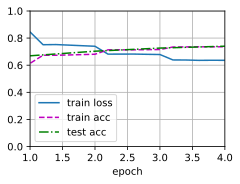

In [ ]:
lr, num_epochs = 0.001, 4
final_state = train_bert_classifier(Transformer, train_iter, test_iter, num_epochs, lr)